In [1]:
import pandas as pd
import numpy as np
from scipy import stats as st
import statsmodels.api as sm
from statsmodels.stats.anova import AnovaRM
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

In [2]:
def cohen_glass_hedges(x,y):
    nx = len(x)
    ny = len(y)
    pstdnmr = (nx-1)*x.var(ddof=1) + (ny-1)*y.var(ddof=1)   # (n-1)(var1+var2)
    pstddnm = nx + ny - 2                                   # (n-1)*2
    pstd = (pstdnmr / pstddnm)**(0.5)
    cohen = (x.mean() - y.mean()) / pstd
    glass = (x.mean() - y.mean()) / x.std(ddof=1)
    hedges = cohen * (1 - 3/(4 * (nx+ny) - 9) )             # cohen * (1-3/(8*n-9))
    return (cohen, glass, hedges)

In [3]:
am = pd.read_csv('aeroscan_full_melt.csv')
ap = pd.read_csv('aeroscan_full_pivot.csv')

#### Dataset parameter description

1. RF – Respiratory frequency (breaths/minute)
2. HF – Heart rate (beats/minute)
3. RER – The ratio of exhaled CO2 to inspired O2 (respiratory exchange rate)
4. Fat - kcal/h fat consumed
5. Carb - kcal/h carbohydrates consumed
6. Energy – kcal/h total energy consumed

* 1, 2, 3 - effort level
* a, b - before/after treatment

In [4]:
am.shape

(3744, 8)

In [5]:
ap.shape

(234, 22)

In [23]:
am = am.drop(columns = 'Unnamed: 0')

In [27]:
am.head(3)

,ID,sex,location,time,level,parameter,value
0,t1,f,Jurilovca,f,1,rrate,20.690417
1,t2,m,Baia,f,1,rrate,38.483108
2,t3,f,Jurilovca,f,1,rrate,34.786918


In [55]:
am.parameter.value_counts()

parameter
rrate          234
hrate          234
ventilation    234
vo2            234
vo2rel         234
vco2           234
vco2rel        234
rer            234
vo2eq          234
vo2pulse       234
fat            234
carb           234
fat100         234
carb100        234
energy         234
met            234
Name: count, dtype: int64

In [168]:
aml = am.copy()

In [169]:
aml.parameter = aml.parameter.replace(dict(zip(['rrate', 'hrate', 'ventilation', 'vo2', 'vo2rel', 'vco2',
       'vco2rel', 'rer', 'vo2eq', 'vo2pulse', 'fat', 'carb', 'fat100',
       'carb100', 'energy', 'met'], ['Respiratory rate (breaths/min)', 'Heart rate (beats/min)',
                                     'Ventilation (l/min)', 'VO2 (l/min)', 'VO2 relative (ml/kg/min)',
                                     'VCO2 (l/min)', 'VCO2 relative (ml/kg/min)',
                                     'Respiratory exchange ratio', 'VO2 Eq (l)',
                                     'VO2 pulse (l)', 'Fat (kcal/h)', 'Carbohydrates (kcal/h)',
                                     'Fat %', 'Carbohydrates %', 'Energy (kcal/h)', 'MET (3.5ml/kg/min)'])))

In [197]:
aml.time = aml.time.replace(dict(zip(['f','i'],['final', 'initial'])))

In [198]:
aml

,ID,sex,location,time,level,parameter,value
0,t1,f,Jurilovca,final,1,Respiratory rate (breaths/min),20.690417
1,t2,m,Baia,final,1,Respiratory rate (breaths/min),38.483108
2,t3,f,Jurilovca,final,1,Respiratory rate (breaths/min),34.786918
3,t4,f,Baia,final,1,Respiratory rate (breaths/min),21.148000
4,t5,m,Jurilovca,final,1,Respiratory rate (breaths/min),29.927656
...,...,...,...,...,...,...,...
3739,t36,m,Baia,initial,3,MET (3.5ml/kg/min),4.550712
3740,t37,m,Jurilovca,initial,3,MET (3.5ml/kg/min),3.217695
3741,t38,m,Jurilovca,initial,3,MET (3.5ml/kg/min),6.790791
3742,t39,m,Baia,initial,3,MET (3.5ml/kg/min),7.371199


In [93]:
ap = am.pivot(columns='parameter', index=['ID', 'sex', 'location', 'time', 'level'], values='value').reset_index()

<Axes: >

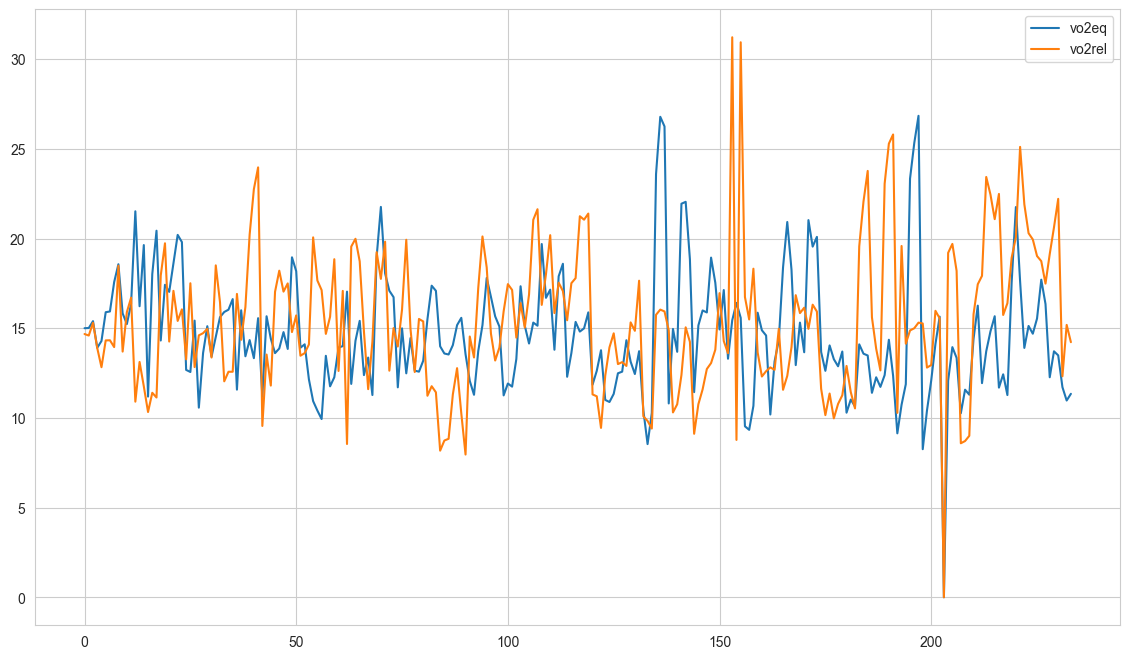

In [269]:
sns.set_style("whitegrid")
mpl.pyplot.figure(figsize=(14,8))
sns.lineplot([ap.vo2eq/2, ap.vo2rel], dashes=False)

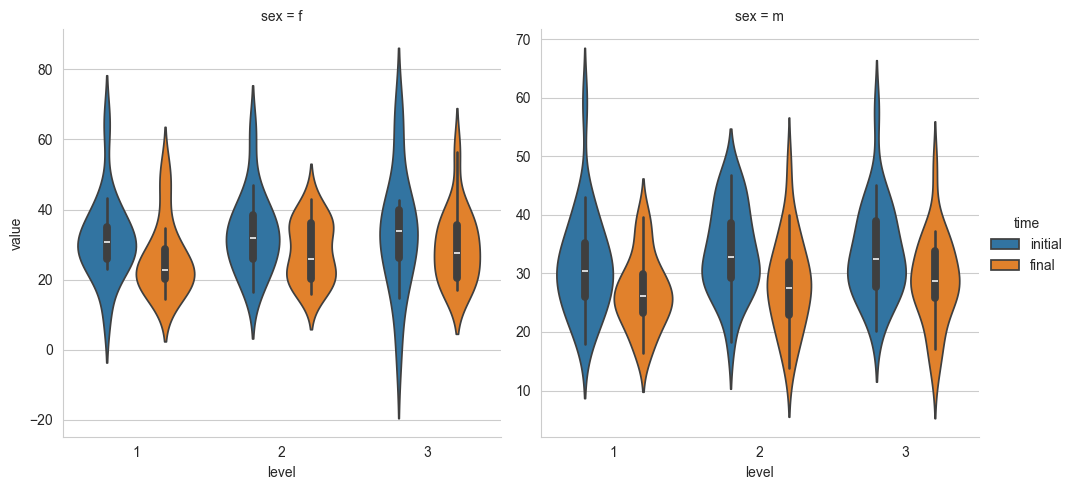

In [255]:
#mpl.pyplot.figure(figsize=(14,8))
sns.catplot(data=aml.loc[aml.parameter=='Respiratory rate (breaths/min)'],
            x='level', y='value', col='sex',
            hue='time', hue_order=['initial','final'],
            sharex=False, sharey=False, 
            kind='violin', split=False, inner='box')
# plt.savefig('spir-detailed-violin-quart.pdf')

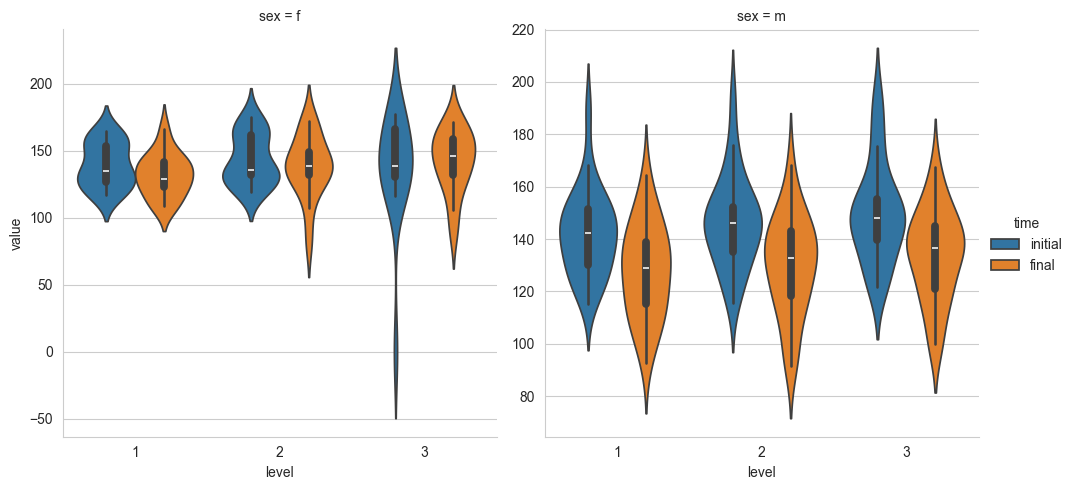

In [256]:
#mpl.pyplot.figure(figsize=(14,8))
sns.catplot(data=aml.loc[aml.parameter=='Heart rate (beats/min)'],
            x='level', y='value', col='sex',
            hue='time', hue_order=['initial','final'],
            sharex=False, sharey=False, 
            kind='violin', split=False, inner='box')
# plt.savefig('spir-detailed-violin-quart.pdf')

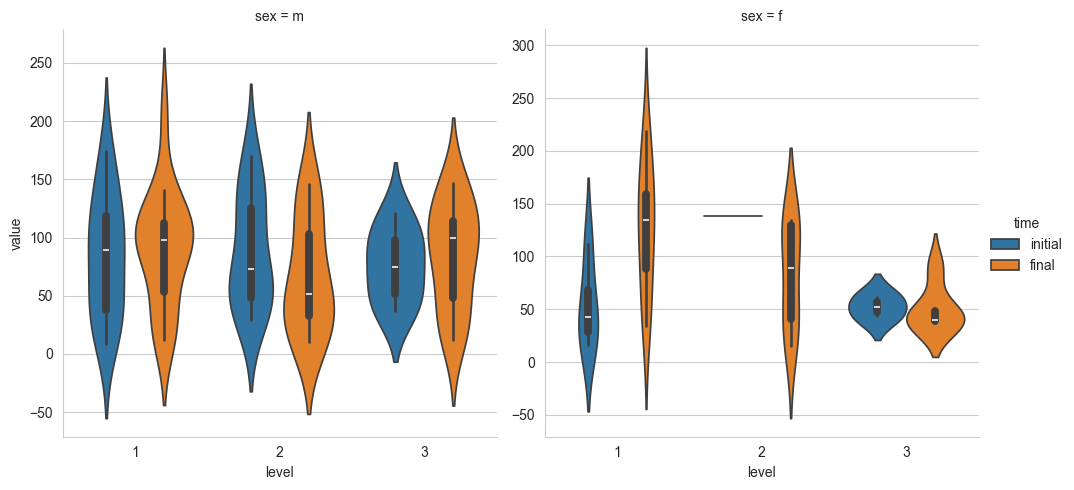

In [258]:
#mpl.pyplot.figure(figsize=(14,8))
sns.catplot(data=aml.loc[(aml.parameter=='Fat (kcal/h)') & (aml.value!=0)],
            x='level', y='value', col='sex',
            hue='time', hue_order=['initial','final'],
            sharex=False, sharey=False, 
            kind='violin', split=False, inner='box')
# plt.savefig('spir-detailed-violin-quart.pdf')

In [252]:
aml.parameter.unique()

array(['Respiratory rate (breaths/min)', 'Heart rate (beats/min)',
       'Ventilation (l/min)', 'VO2 (l/min)', 'VO2 relative (ml/kg/min)',
       'VCO2 (l/min)', 'VCO2 relative (ml/kg/min)',
       'Respiratory exchange ratio', 'VO2 Eq (l)', 'VO2 pulse (l)',
       'Fat (kcal/h)', 'Carbohydrates (kcal/h)', 'Fat %',
       'Carbohydrates %', 'Energy (kcal/h)', 'MET (3.5ml/kg/min)'],
      dtype=object)

In [200]:
for i in ap.columns[6:]:
    print(i, AnovaRM(data=ap, depvar=i, subject='ID', within=['time','level']).fit())

carb100                  Anova
           F Value Num DF  Den DF Pr > F
----------------------------------------
time        3.4609 1.0000 38.0000 0.0706
level      12.5791 2.0000 76.0000 0.0000
time:level  3.5691 2.0000 76.0000 0.0330

energy                  Anova
           F Value Num DF  Den DF Pr > F
----------------------------------------
time        4.7336 1.0000 38.0000 0.0359
level       0.8888 2.0000 76.0000 0.4154
time:level  0.7176 2.0000 76.0000 0.4912

fat                  Anova
           F Value Num DF  Den DF Pr > F
----------------------------------------
time        4.2986 1.0000 38.0000 0.0450
level      14.4401 2.0000 76.0000 0.0000
time:level  4.9251 2.0000 76.0000 0.0097

fat100                  Anova
           F Value Num DF  Den DF Pr > F
----------------------------------------
time        4.0710 1.0000 38.0000 0.0507
level      15.2965 2.0000 76.0000 0.0000
time:level  4.4499 2.0000 76.0000 0.0149

hrate                  Anova
           F Value Num DF  De